#**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**importing Libraries**

In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os

#**Reading Data**

In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')

# Load the Sentiment140 dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, usecols=[0, 5], names=['target', 'text'])
df.columns = ['sentiment', 'text']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**Data Pre-Processing**

In [ ]:
# Convert sentiment to binary (0: negative, 1: positive)
df['sentiment'] = df['sentiment'].replace({4: 1})

# Function to clean the tweets
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    return tweet

# Function to preprocess the tweets
def preprocess_tweet(tweet, stop_words, stemmer):
    tweet = clean_tweet(tweet)
    words = tweet.split()
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

# Initialize stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Apply preprocessing to the text
df['text'] = df['text'].apply(lambda x: preprocess_tweet(x, stop_words, stemmer))

#**Saving Pre-Processed Data to Drive (Un-vectorized)**

In [ ]:
import os

# Define file path
drive_path = '/content/drive/MyDrive/Computational Intelligence in Automation'
os.makedirs(drive_path, exist_ok=True)

# Assuming df is your preprocessed DataFrame
data_path = os.path.join(drive_path, 'preprocessed_data.csv')

# Save the DataFrame as a CSV file
df.to_csv(data_path, index=False)

print("Preprocessed data saved to Google Drive.")

Preprocessed data saved to Google Drive.


In [ ]:
df_preprocessed = pd.read_csv('/content/drive/MyDrive/Computational Intelligence in Automation/preprocessed_data.csv')
display(df_preprocessed)

,sentiment,text
0,0,that bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav im mad cant see
...,...,...
1599995,1,woke school best feel ever
1599996,1,thewdbcom cool hear old walt interview â
1599997,1,readi mojo makeov ask detail
1599998,1,happi th birthday boo alll time tupac amaru sh...


#**Removing NaN Values**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os


# Check for NaN values in 'text' column
print("Checking for NaN values in 'text' column:")
print(df_preprocessed['text'].isna().sum())


Checking for NaN values in 'text' column:
7211


In [ ]:
# Handle NaN values (remove rows with NaN in 'text' column)
df_final = df_preprocessed.dropna(subset=['text'])

#**Vectorization**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_final['text'], df_final['sentiment'], test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [ ]:
print(X_train_vect.shape)
print(X_test_vect.shape)

(1274231, 10000)
(318558, 10000)


#**Logistic Regression (Non Private)**

Accuracy without DP: 77.69%


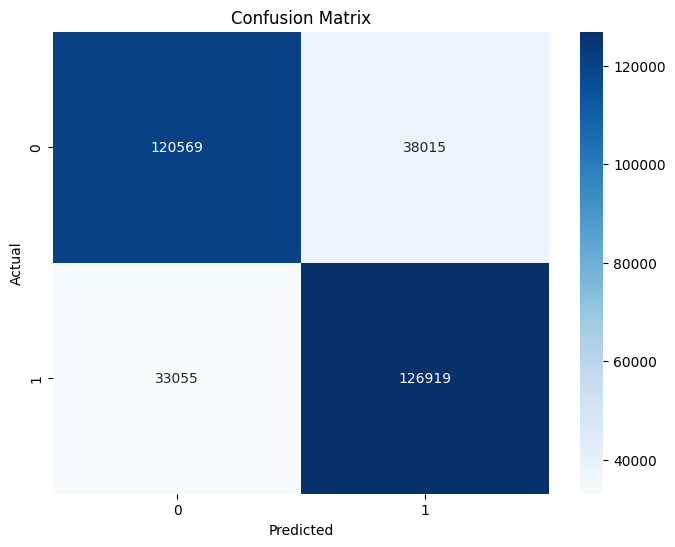

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train logistic regression without differential privacy
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vect, y_train)

# Evaluate the model
y_pred = model.predict(X_test_vect)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy without DP: {accuracy * 100:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Save the plot as an SVG file
plt.savefig("confusion_matrix.svg", format='svg')

plt.show()

#**Model With Differential Privacy**

In [ ]:
pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 1.3 MB/s eta 0:00:00


Accuracy with epsilon=0.1: 0.5301577734666842
Accuracy with epsilon=0.5: 0.5126444791843243
Accuracy with epsilon=1.0: 0.4939069180494604
Accuracy with epsilon=5.0: 0.5525524394301823
Accuracy with epsilon=10.0: 0.5733335844649954


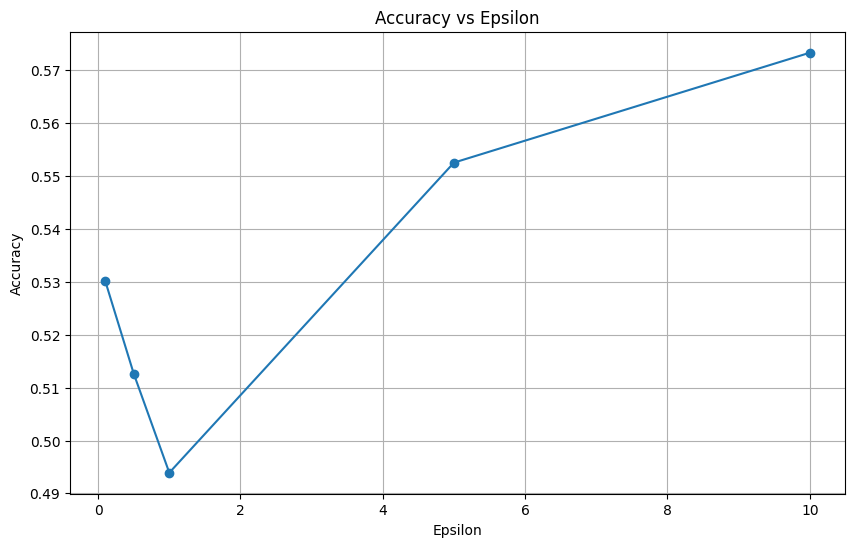

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from diffprivlib.models import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc

def train_model_with_dp(X_train, X_test, y_train, y_test, epsilon, batch_size=1000):
    # Initialize the differentially private logistic regression model
    model = LogisticRegression(epsilon=epsilon, data_norm=2.0)  # Adjust data_norm according to your data

    # Train the model in batches
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Convert to numpy array if necessary
        X_batch = X_batch.toarray() if isinstance(X_batch, csr_matrix) else X_batch

        # Train the model on the batch
        model.fit(X_batch, y_batch)

        # Clear memory after each batch
        del X_batch, y_batch
        gc.collect()

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Define a range of epsilon values to test
epsilon_values = [0.1, 0.5, 1.0, 5.0, 10.0]
batch_size = 100000  # Adjust as needed

accuracies = []

# Iterate over different epsilon values
for epsilon in epsilon_values:
    accuracy = train_model_with_dp(X_train_vect, X_test_vect, y_train, y_test, epsilon, batch_size)
    accuracies.append(accuracy)
    print(f"Accuracy with epsilon={epsilon}: {accuracy}")

# Plot accuracy vs epsilon
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracies, marker='o')
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
